In [1]:
#import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
#Setting the random seed 
import random
seed = 42
np.random.seed(seed) 
random.seed(seed)

In [3]:
#Importing data
data = pd.read_excel('default of credit card clients.xls',header=1)
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [5]:
#replace values 0, 5, 6 with 4 (others category) since they are not mentioned in the data description
data['EDUCATION'].replace([0,5,6],4,inplace=True)
data.EDUCATION.value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

In [6]:
#initial preprocessing: drop 'ID' column, rename target column to DEFAULT, rename PAY_0 to PAY_1 for consistency 
data.drop(columns='ID',inplace=True)
data.rename(columns={"default payment next month": "DEFAULT","PAY_0": "PAY_1"},inplace=True)

In [7]:
#train test split (30%) before scaling and encoding to prevent data leakage 
X_train, X_test, y_train, y_test = train_test_split(data.drop('DEFAULT',axis=1),data['DEFAULT'],test_size=0.3,stratify=data['DEFAULT'])

In [8]:
#one hot encode categorical features and drop the first generated column to prevent multicollinearity
#first ohe train and save columns to apply to test set
X_train_encoded = pd.get_dummies(X_train, columns = ['EDUCATION','MARRIAGE','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'], drop_first = True)
cols_train = X_train_encoded.columns.tolist()

In [9]:
#ohe X_test and apply the same columns from X_train_encoded
X_test_encoded = pd.get_dummies(X_test,columns = ['EDUCATION','MARRIAGE','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'], drop_first = True)
X_test_encoded = X_test_encoded.reindex(columns = cols_train).fillna(0)   #if unknown columns assign 0

In [10]:
#numerical columns
numerical_cols = ['LIMIT_BAL', 'AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [11]:
#Scaling numerical features
scaler = RobustScaler()

# Fit and transform the scaler on the training data
X_train_scaled_encoded = copy.deepcopy(X_train_encoded)
X_train_scaled_encoded[numerical_cols] = scaler.fit_transform(X_train_encoded[numerical_cols])

# Transform the test data using the fitted scaler
X_test_scaled_encoded = copy.deepcopy(X_test_encoded)
X_test_scaled_encoded[numerical_cols] = scaler.transform(X_test_encoded[numerical_cols])

In [12]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o',over),('u',under)]
pipeline = Pipeline(steps=steps)

In [13]:
X_train_SMOTE = copy.deepcopy(X_train_scaled_encoded)
y_train_SMOTE = copy.deepcopy(y_train)

In [14]:
X_train_SMOTE, y_train_SMOTE =  pipeline.fit_resample(X_train_SMOTE, y_train_SMOTE)

In [15]:
# Create a LogisticRegression object, max_iter=300 to remove the warning "ConvergenceWarning: lbfgs failed to converge (status=1)"
logreg = LogisticRegression(max_iter=600)

# Fit the model on the training data
logreg.fit(X_train_SMOTE, y_train_SMOTE)

# Predict on the test data
y_pred = logreg.predict(X_test_scaled_encoded)

In [16]:
X_train_SMOTE.columns

Index(['LIMIT_BAL', 'SEX', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'EDUCATION_2',
       'EDUCATION_3', 'EDUCATION_4', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3',
       'PAY_1_-1', 'PAY_1_0', 'PAY_1_1', 'PAY_1_2', 'PAY_1_3', 'PAY_1_4',
       'PAY_1_5', 'PAY_1_6', 'PAY_1_7', 'PAY_1_8', 'PAY_2_-1', 'PAY_2_0',
       'PAY_2_1', 'PAY_2_2', 'PAY_2_3', 'PAY_2_4', 'PAY_2_5', 'PAY_2_6',
       'PAY_2_7', 'PAY_2_8', 'PAY_3_-1', 'PAY_3_0', 'PAY_3_1', 'PAY_3_2',
       'PAY_3_3', 'PAY_3_4', 'PAY_3_5', 'PAY_3_6', 'PAY_3_7', 'PAY_3_8',
       'PAY_4_-1', 'PAY_4_0', 'PAY_4_1', 'PAY_4_2', 'PAY_4_3', 'PAY_4_4',
       'PAY_4_5', 'PAY_4_6', 'PAY_4_7', 'PAY_4_8', 'PAY_5_-1', 'PAY_5_0',
       'PAY_5_2', 'PAY_5_3', 'PAY_5_4', 'PAY_5_5', 'PAY_5_6', 'PAY_5_7',
       'PAY_5_8', 'PAY_6_-1', 'PAY_6_0', 'PAY_6_2', 'PAY_6_3', 'PAY_6_4',
       'PAY_6_5', 'PAY_6_6', 'PAY_6_7', 'PAY_

In [17]:
#Even though the accuracy is good, the other metrics are not that good due to the imbalance of the dataset 
print('Accuracy:', accuracy_score(y_test,y_pred))
print('Precision:', precision_score(y_test,y_pred))
print('Recall:', recall_score(y_test,y_pred))
print('F1 score:', f1_score(y_test,y_pred))

Accuracy: 0.811
Precision: 0.6064610866372981
Recall: 0.4148669010547464
F1 score: 0.4926931106471817


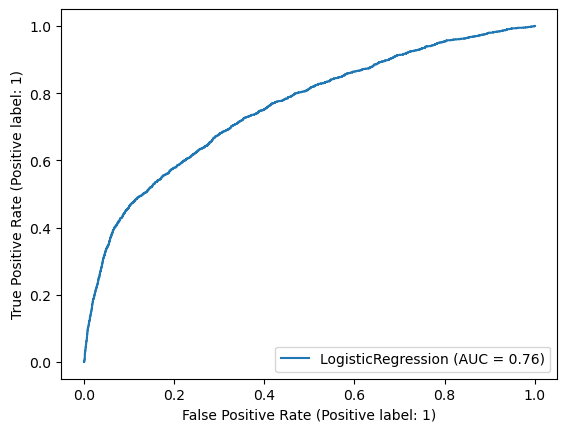

In [18]:
#ROC Curve plot - VIF
RocCurveDisplay.from_estimator(logreg, X_test_scaled_encoded, y_test)

In [19]:
import xgboost as xgb

# Train an XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_SMOTE, y_train_SMOTE)

# Make predictions on the validation set
y_pred3 = xgb_model.predict(X_test_scaled_encoded)

print('Accuracy:', accuracy_score(y_test,y_pred3))
print('Precision:', precision_score(y_test,y_pred3))
print('Recall:', recall_score(y_test,y_pred3))
print('F1 score:', f1_score(y_test,y_pred3))

Accuracy: 0.8063333333333333
Precision: 0.5827770360480641
Recall: 0.4384731290808639
F1 score: 0.5004299226139295


In [20]:
from sklearn.ensemble import RandomForestClassifier

# Train an RF model
rf_model = RandomForestClassifier()
rf_model.fit(X_train_SMOTE, y_train_SMOTE)

# Make predictions on the validation set
y_pred4 = rf_model.predict(X_test_scaled_encoded)

print('Accuracy:', accuracy_score(y_test,y_pred4))
print('Precision:', precision_score(y_test,y_pred4))
print('Recall:', recall_score(y_test,y_pred4))
print('F1 score:', f1_score(y_test,y_pred4))

Accuracy: 0.8066666666666666
Precision: 0.5830575777630708
Recall: 0.44249121044701156
F1 score: 0.5031410622501429
